In [1]:
import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.optim as optim
import numpy as np
import torchvision
from torch.optim.optimizer import Optimizer
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy

import utilits

In [2]:
data_dir = "/home/nikita/PycharmProjects/hymenoptera_data"
num_classes = 2
batch_size = 8
num_epochs = 25
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

False


In [3]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
model_ft = models.alexnet(pretrained=True)

set_parameter_requires_grad(model_ft, feature_extracting=False)

params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# replace last layer from alexNet to custom classification
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

state_sizes, dataloaders_dict = utilits.image_data(data_dir, batch_size)

In [7]:
def train_model_single_epoch(model:nn.Module, image_data:dict, criterion:nn.CrossEntropyLoss, optimizer:Optimizer,
                            epoch:int, is_grad = True):
    state = 'train'
    model.train()
    for inputs, labels in image_data[state]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # flush evaluated gradients
        # what different ?
        optimizer.zero_grad()
        #model.zero_grad()
        
        output = model(inputs)
        loss = criterion(output, labels)
        if is_grad:
            loss.backward()
        # why bellow command ?
        optimizer.step()      
        
    return model

In [8]:
def validate_model_single_epoch(model:nn.Module, image_data:dict, criterion:nn.CrossEntropyLoss, epoch:int):
    state = 'val'
    model.eval()
    sum_loss = 0
    correct_accumulate = 0
    for inputs, labels in image_data[state]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs)
        loss = criterion(output, labels)
        model_answer = torch.max(output, 1)[1]
        corrects = batch_size - ((model_answer + labels) % 2).sum().item()
        sum_loss += loss.item() * batch_size
        correct_accumulate += corrects
    
    epoch_loss = sum_loss / state_sizes[state]
    epoch_acc = float(correct_accumulate) / state_sizes[state]
    print("epoch: {}, corrects:{:.4f}, loss:{:.4f}".format(epoch, epoch_acc, epoch_loss))
    return epoch_acc

In [9]:
def train_model(model, image_data, criterion, optimizer, num_epochs=25, is_grad=True):
    best_model_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        m = train_model_single_epoch(model, image_data, criterion, optimizer, epoch, is_grad)
        acc = validate_model_single_epoch(m, image_data, criterion, epoch)
        if acc > best_acc:
            best_acc = acc
            best_model_state = copy.deepcopy(m.state_dict())
    
    best_model = model.load_state_dict(best_model_state)
    print(best_acc)
    print(best_model)
    return best_model

In [10]:
trained_model = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft)

Epoch 0/24
----------
epoch: 0, corrects:0.8497, loss:0.4499
Epoch 1/24
----------
epoch: 1, corrects:0.9216, loss:0.4158
Epoch 2/24
----------
epoch: 2, corrects:0.9150, loss:0.3640
Epoch 3/24
----------
epoch: 3, corrects:0.9020, loss:0.4004
Epoch 4/24
----------
epoch: 4, corrects:0.9216, loss:0.3876
Epoch 5/24
----------
epoch: 5, corrects:0.9477, loss:0.3656
Epoch 6/24
----------
epoch: 6, corrects:0.9085, loss:0.5285
Epoch 7/24
----------
epoch: 7, corrects:0.9477, loss:0.3414
Epoch 8/24
----------
epoch: 8, corrects:0.9412, loss:0.3912
Epoch 9/24
----------
epoch: 9, corrects:0.9281, loss:0.3954
Epoch 10/24
----------
epoch: 10, corrects:0.9281, loss:0.3575
Epoch 11/24
----------
epoch: 11, corrects:0.9608, loss:0.3822
Epoch 12/24
----------
epoch: 12, corrects:0.9412, loss:0.3862
Epoch 13/24
----------
epoch: 13, corrects:0.9346, loss:0.4379
Epoch 14/24
----------
epoch: 14, corrects:0.9150, loss:0.5164
Epoch 15/24
----------
epoch: 15, corrects:0.9281, loss:0.4536
Epoch 16/24


In [23]:
model_conv = models.alexnet(pretrained=True)
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs,num_classes)

params = []
for param in model_conv.parameters():
    param.requires_grad = False
    params.append(param)
optimizer_conv = optim.SGD(params, lr=0.001, momentum=0.9)

In [24]:
trained_model_conv = train_model(model_conv, dataloaders_dict, criterion, optimizer_conv, num_epochs=15, is_grad=False)



""""

d) 
H =
1 1 1 1 1 1
0 1 0 1 1 0
0 0 1 0 1 1
=>
H = 
1 1 0 1 0 0
1 0 0 0 1 0
1 0 1 0 0 1
G = 
1 0 0 1 1 1
0 1 0 1 0 0
0 0 1 0 0 1
=> r = 3, k = 3, n = 6, d = 1
 
e) 
G = 
0 0 1 0 1 1
1 1 1 1 1 1
1 0 1 1 0 0
=> 
G = 
0 0 1 1 0 0
1 1 1 0 1 0
1 1 1 0 0 1
H = 
0 0 1 1 0 0
1 1 1 0 1 0
1 1 1 0 0 1
n = 6, k = 3, r = 3, d = 1

f) 
G = 
0 1 0 1 1 0
1 1 1 1 1 1 
=> 
G = 
1 0 1 0 0 1
0 1 0 1 1 0
H = 
1 0 1 0 0 0 
0 1 0 1 0 0
0 1 0 0 1 0
1 0 0 0 0 1
  ^   ^ ^
=>
n = 6, k =2, r = 4, d = 2 
g)
H = 
0 1 0 1 1 0 0
1 0 1 1 0 1 0
1 1 1 1 1 1 1
  ^     ^
=> 
H =
0 1 0 1 1 0 0
1 0 1 1 0 1 0
0 0 0 1 0 0 1
=>
G =
1 0 0 0 0 1 0
0 1 0 0 1 0 0
0 0 1 0 0 1 0
0 0 0 1 1 1 1
=>
n = 7, k = 4, r = 3, d = 1

h)
G = 
1 1 1 0 1 0 0
0 1 1 1 0 1 0
0 0 1 1 1 0 1
=> 
G = 
1 0 0 1 1 1 0
0 1 0 0 1 1 1
0 0 1 1 1 0 1
=>
H = 
1 0 1 1 0 0 0
1 1 1 0 1 0 0
1 1 0 0 0 1 0
0 1 1 0 0 0 1
^     ^ ^ ^
=> 
n = 7, k = 3, r = 4, d = 3

i)
H = 
1 1 1 0 1 0 0
0 1 1 1 0 1 0
1 1 1 1 1 1 1
^       ^
=> 
H = 
1 1 1 0 1 0 0 
0 1 1 1 0 1 0
0 1 1 0 0 0 1
=> 
G = 
1 0 0 1 0 0 0
1 1 1 0 1 0 0
1 1 1 0 0 1 0
0 1 0 0 0 0 1
=> 
n = 7, k = 4, r = 3, d = 1

"""

Epoch 0/14
----------
epoch: 0, corrects:0.5752, loss:0.7454
Epoch 1/14
----------
epoch: 1, corrects:0.5752, loss:0.6931
Epoch 2/14
----------
epoch: 2, corrects:0.5752, loss:0.7215
Epoch 3/14
----------
epoch: 3, corrects:0.5752, loss:0.6915
Epoch 4/14
----------
epoch: 4, corrects:0.5752, loss:0.6903
Epoch 5/14
----------
epoch: 5, corrects:0.5752, loss:0.7229
Epoch 6/14
----------
epoch: 6, corrects:0.5752, loss:0.6956
Epoch 7/14
----------
epoch: 7, corrects:0.5752, loss:0.6935
Epoch 8/14
----------
epoch: 8, corrects:0.5752, loss:0.7454
Epoch 9/14
----------
epoch: 9, corrects:0.5752, loss:0.7066
Epoch 10/14
----------
epoch: 10, corrects:0.5752, loss:0.6941
Epoch 11/14
----------
epoch: 11, corrects:0.5752, loss:0.7106
Epoch 12/14
----------
epoch: 12, corrects:0.5752, loss:0.7062
Epoch 13/14
----------
epoch: 13, corrects:0.5752, loss:0.7438
Epoch 14/14
----------
epoch: 14, corrects:0.5752, loss:0.7209
0.5751633986928104
<All keys matched successfully>


[0.5691011400000001, 0.6513124383000002, 0.7175702976840004, 0.7712320727218503, 0.8146979798789038, 0.8499053641763854, 0.8784233453999499, 0.9015229097775138, 0.9202335569213986, 0.9353891811077326, 0.9476652366972641, 0.9576088417247846, 0.9656631617970758, 0.9721871610556316, 0.9774716004550617, 0.9817519963686003, 0.9852191170585665]
[0.0772553001108834, 0.09561792499002673, 0.11361512828387049, 0.1312541872310217, 0.14854222890512433, 0.16548623854991237, 0.18209306240276912, 0.198369410460954, 0.214321859192781, 0.22995685419484466, 0.24528071279636723, 0.2602996266117195, 0.2750196640421463, 0.2894467727277076, 0.3035867819504261, 0.3174454049896126, 0.3310282414303194]
[0.007972055930000112, 0.009955119790251791, 0.011934219505791075, 0.013909363000999002, 0.015880558184360002, 0.017847812948549473, 0.019811135170465316, 0.021770532711259557, 0.023726013416369752, 0.025677585115550426, 0.02762525562290444, 0.02956903273691425, 0.03150892424047316, 0.03344493790091646, 0.035377

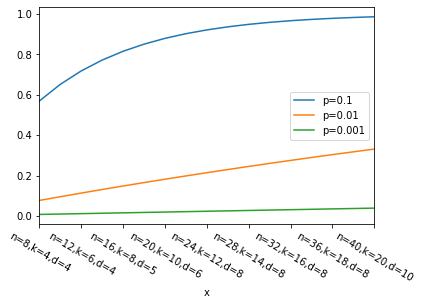

In [80]:
import scipy.special as sc 
import pandas as pd

def f(n:int, d:int, p:float):
    a = 0
    for i in range(d, n):
        a += sc.comb(n, i) * (p ** (n - i)) * ((1 - p) ** i)  
    return a 

n = [i for i in range(8, 42, 2)]
k = [i for i in range(4, 21)]
d = [4, 4, 4, 4, 5, 6, 6, 7, 8, 7, 8, 8, 8, 8, 8, 9, 10]
nkd = list(map(lambda x: "n={},k={},d={}".format(x[0], x[1], x[2]), zip(n, k, d)))

composed = {'x' : nkd}
probs = [0.1, 0.01, 0.001]

indexes = ['x']
indexes.extend('p={}'.format(p) for p in probs)

for p in probs:
    ans = []
    for item in range(len(n)):
        res = f(n[item], d[item], p)
        ans.append(res)
    composed['p={}'.format(p)] = ans
    print(ans)
            
df = pd.DataFrame(composed)
df = df[indexes]
df.set_index('x', inplace=True)
df.plot(rot=-30)

In [ ]:
import scipy.integrate as integrate
import pandas as pd

n = [i for i in range(8, 42, 2)]
k = [i for i in range(4, 21)]
d = [4, 4, 4, 4, 5, 6, 6, 7, 8, 7, 8, 8, 8, 8, 8, 9, 10]
nkd = list(map(lambda x: "n={},k={},d={}".format(x[0], x[1], x[2]), zip(n, k, d)))

composed = {'x' : nkd}
probs = [0.1, 0.01, 0.001]